# Combining Models

Now we might want to combine different models together. For example, we might want to fit a transit simultaneously with its systematics (polynomials in time, x, y, background etc.). This is very similar to the Transit and Polynomial tutorials, so if you haven't looked at those tutorials I recommend you do before this one!

In [1]:
# import chromatic_fitting of course!
from chromatic_fitting import *

# import any prior distributions we want to use for our parameters - I've chosen Normal and Uniform from pymc3
# and QuadLimbDark and ImpactParameter from exoplanet
from pymc3 import Normal, Uniform
from exoplanet import QuadLimbDark, ImpactParameter

# import astropy table just for this tutorial (pandas dataframes don't show up nicely on the docs pages!)
from astropy.table import Table

plt.matplotlib.style.use('default')

Running chromatic_fitting v0.9.2!

This program is running on:
Python v3.9.12 (main, Jun  1 2022, 06:34:44) 
[Clang 12.0.0 ]
numpy v1.22.1
chromatic v0.4.5
pymc3 v3.11.5
pymc3_ext v0.1.1
exoplanet v0.5.2


Generate some simulated data. This time we will use the handy `.inject_systematics()` and `.inject_noise()` functions in `chromatic`

  0%|          | 0/231 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

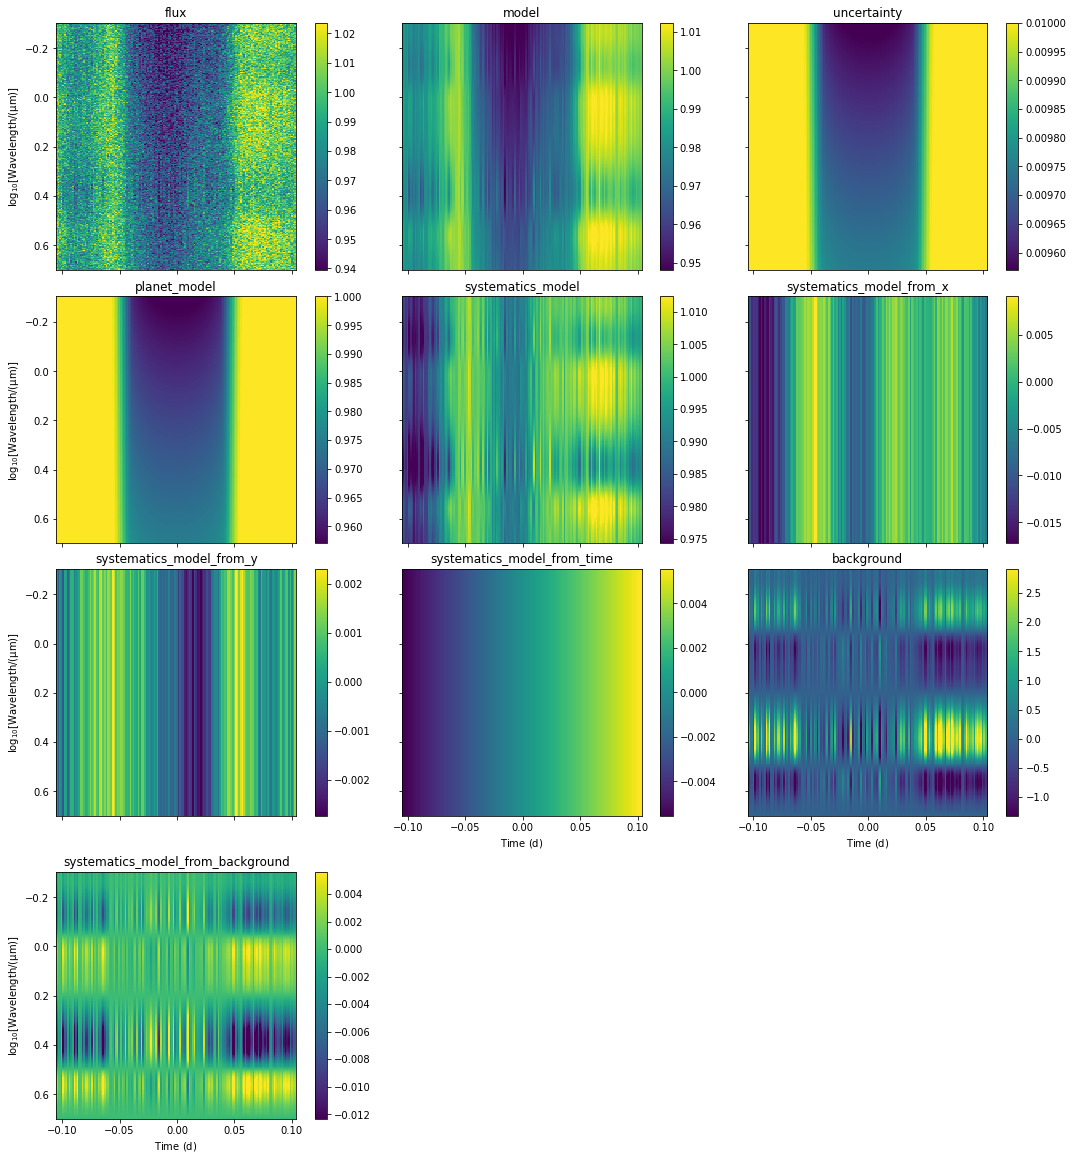

In [108]:
# create a basic simulated data set
s = SimulatedRainbow()
# inject a transit and noise as well as systematics in x, y, background and time.
s = s.inject_transit(planet_radius=np.linspace(0.2, 0.15, s.nwave)).inject_noise(signal_to_noise=100).inject_systematics(amplitude=0.005)

ramp = np.array([np.ones(s.ntime)] * s.nwave)
A = 0.02
decay_time = 0.01
C = 1
ramp = A * np.exp(-(s.time.to_value('d')-s.time[0].to_value('d'))/decay_time) + C
s.flux = s.flux * ramp

# show all the Rainbow.fluxlike quantities:
s.imshow_quantities();
# finally, we will bin our lightcurves to make this tutorial run faster!
nwave = 5
s = s.bin(nwavelengths=int(s.nwave/nwave), dt=5 * u.minute)

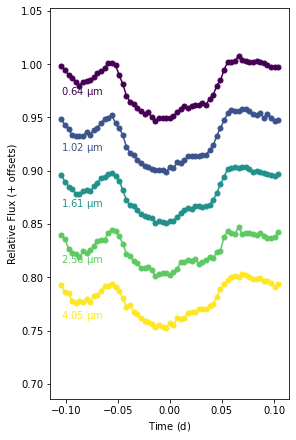

In [109]:
s.plot_lightcurves();

Set up the transit and polynomial models. This is where we can set the distributions for every parameter, the names of the models, the degree of the polynomials, the variables we want to relate the polynomials to, etc. Here we decided to just model linear polynomials (with degree=1) for each systematic variable: 

In [110]:
# set up transit model:
t = TransitModel()
t.setup_parameters(
                  period=1,
                   epoch=Fitted(Uniform,lower=-0.05,upper=0.05),
                   stellar_radius = Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   stellar_mass =Fitted(Uniform, lower=0.8, upper=1.2,testval=1),
                   radius_ratio=WavelikeFitted(Normal, mu=0.1, sigma=0.05),
                   impact_parameter=Fitted(ImpactParameter,ror=0.15,testval=0.44),
                   limb_darkening=WavelikeFitted(Uniform,testval=[0.05,0.35],shape=2),
                    baseline = WavelikeFitted(Normal, mu=1.0, sigma=0.1)
                )

# set up time polynomial model:
b = PolynomialModel(degree=1, name='stime')
b.setup_parameters(
    p_0 = 1.0,
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up x polynomial model:
b_x = PolynomialModel(degree=1, independant_variable="x", name='sx')
b_x.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up y polynomial model:
b_y = PolynomialModel(degree=1, independant_variable="y", name='sy')
b_y.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# set up bkg polynomial model:
b_bkg = PolynomialModel(degree=1, independant_variable="background", name='sbkg')
b_bkg.setup_parameters(
    p_1 = Fitted(Normal,mu=0.0,sigma=0.01),
)

# add ramp model:
ramp = ExponentialModel(t0=s.time[0])
ramp.setup_parameters(
    A = Fitted(Uniform,testval=0.01,upper=0.05,lower=-0.05),
    decay_time = Fitted(Uniform,testval=0.001,upper=0.01,lower=0),
    baseline = 0
)

We can combine the models by using the standard arithmetic operators: +, -, * and /. In this case I will multiply the transit model by the sum of all the systematic polynomials. *Note: we have to be careful here not to have multiple different variables that all describe some constant offset.* For example, in the transit model we have the 'baseline' parameter that determines the out-of-transit constant flux. But in the polynomials we can also fit for the 0th order flux, 'p_0'. We should be careful not to fit for both! (By default 'p_0' will be set to 0.0 in the models where we don't define it.)

In [111]:
cmod = t * (b + b_x + b_y + b_bkg + ramp)
cmod

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:186: UserWarning: stime in the parameter name: stime_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:186: UserWarning: sx in the parameter name: sx_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:186: UserWarning: sy in the parameter name: sy_p_0. Please avoid having the model name in the parameter name as it can get confusing!
  warnings.warn(
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/lightcurve.py:186: UserWarning: sbkg in the parameter name: sbkg_p_0. Please av

<chromatic combined model 'combined' 🌈, models: <chromatic polynomial model 'stime' 🌈> + <chromatic polynomial model 'sx' 🌈> + <chromatic polynomial model 'sy' 🌈> + <chromatic polynomial model 'sbkg' 🌈> + <chromatic exponential model 'exponential' 🌈> * <chromatic transit model 'transit' 🌈>

The individual models will be stored in a dictionary under `.chromatic_models`:

In [112]:
cmod._chromatic_models

{'stime': <chromatic polynomial model 'stime' 🌈>,
 'sx': <chromatic polynomial model 'sx' 🌈>,
 'sy': <chromatic polynomial model 'sy' 🌈>,
 'sbkg': <chromatic polynomial model 'sbkg' 🌈>,
 'exponential': <chromatic exponential model 'exponential' 🌈>,
 'transit': <chromatic transit model 'transit' 🌈>}

Let's see what parameters we have in our models:

In [113]:
cmod.summarize_parameters()

A CombinedModel itself does not have any parameters, however each of its constituent models do:

stime_p_0 =
  <🧮 Fixed | 1.0 🧮>

stime_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='stime_p_1') 🧮>

sx_p_0 =
  <🧮 Fixed | 0.0 🧮>

sx_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sx_p_1') 🧮>

sy_p_0 =
  <🧮 Fixed | 0.0 🧮>

sy_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sy_p_1') 🧮>

sbkg_p_0 =
  <🧮 Fixed | 0.0 🧮>

sbkg_p_1 =
  <🧮 Fitted Normal(mu=0.0, sigma=0.01, name='sbkg_p_1') 🧮>

exponential_A =
  <🧮 Fitted Uniform(testval=0.01, upper=0.05, lower=-0.05, name='exponential_A') 🧮>

exponential_decay_time =
  <🧮 Fitted Uniform(testval=0.001, upper=0.01, lower=0, name='exponential_decay_time') 🧮>

exponential_baseline =
  <🧮 Fixed | 0 🧮>

transit_stellar_radius =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_radius') 🧮>

transit_stellar_mass =
  <🧮 Fitted Uniform(lower=0.8, upper=1.2, testval=1, name='transit_stellar_mass') 🧮>

transit_radius_rati

Then we just attach the Rainbow data to the model and run `.setup_lightcurves()` and `.setup_likelihood()` as in the previous tutorials:

In [114]:
# attach the data to our model
cmod.attach_data(s)

# If we don't want to fit everything simultaneously we can change the optimization method (the options 
# are "separate" or "white_light"). This has to be set BEFORE running .setup_lightcurves!
# cmod.choose_optimization_method('separate')

# The 'store_models' keyword can be useful later to speed up debugging/plotting, but it can slow 
# down/break fitting for large numbers of wavelengths
cmod.setup_lightcurves() # (store_models=True)

# Finally use the observed data to fit the model (assuming Gaussian errors!)
cmod.setup_likelihood()

  0%|          | 0/1 [00:00<?, ?it/s]

In [115]:
cmod._chromatic_models

{'stime': <chromatic polynomial model 'stime' 🌈>,
 'sx': <chromatic polynomial model 'sx' 🌈>,
 'sy': <chromatic polynomial model 'sy' 🌈>,
 'sbkg': <chromatic polynomial model 'sbkg' 🌈>,
 'exponential': <chromatic exponential model 'exponential' 🌈>,
 'transit': <chromatic transit model 'transit' 🌈>}

If we look at our `PyMC3` model we can see that it has a lot of parameters (the combination of all our models) to optimize! If we've chosen the separate wavelength fitting method (`.choose_optimization_method("separate")`) then `._pymc3_model` will return a list of PyMC3 models (one for each wavelength).

In [116]:
print(cmod._pymc3_model)

                        stime_p_1 ~ Normal
                           sx_p_1 ~ Normal
                           sy_p_1 ~ Normal
                         sbkg_p_1 ~ Normal
         exponential_A_interval__ ~ TransformedDistribution
exponential_decay_time_interval__ ~ TransformedDistribution
         transit_epoch_interval__ ~ TransformedDistribution
transit_impact_parameter_impact__ ~ TransformedDistribution
transit_stellar_radius_interval__ ~ TransformedDistribution
  transit_stellar_mass_interval__ ~ TransformedDistribution
transit_limb_darkening_interval__ ~ TransformedDistribution
             transit_radius_ratio ~ Normal
                 transit_baseline ~ Normal
                    exponential_A ~ Uniform
           exponential_decay_time ~ Uniform
                    transit_epoch ~ Uniform
         transit_impact_parameter ~ ImpactParameter
           transit_stellar_radius ~ Uniform
             transit_stellar_mass ~ Uniform
                     transit_a_R* ~ Deterministic


We've got our polynomial parameters (`stime_p_1, sx_p_1, sy_p_1, sbkg_p_1`), our transit parameters that are wavelength-independant in this case (`epoch, impact_parameter, stellar_radius, stellar_mass, a_R*, limb_darkening`) and the wavelength-dependant parameters we've defined to be `radius_ratio_w{N}` only. The `wavelength_{N}_data` parameter just represents the fit of the data to the model at each wavelength (which we've defined to be a Normal distribution). If we've decided to `store_models` then we will also see a bunch of models!

But what do the actual light curves look like?

The summarize step has not been run yet. To include the 'best-fit' model please run {self}.sample() and {self}.summarize() before calling this step!


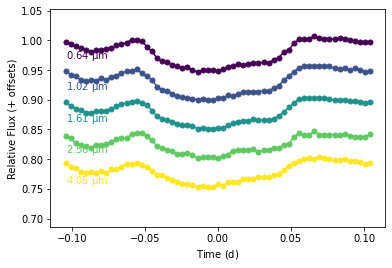

In [117]:
cmod.plot_lightcurves()

We can still see the transit for each wavelength, but it's clear that the systematics would affect any derivation of the transit parameters if we didn't model for these systematics! 

## PyMC3 Sampling

Now we can run the NUTS sampling for our light curves (first by optimizing our initial values)

In [118]:
# optimize for initial values!
opt = cmod.optimize(plot=False)

# put those initial values into the sampling and define the number of tuning and draw steps, 
# as well as the number of chains. NOTE: if you do separate wavelength fitting then the number of steps 
# is per wavelengths, not divided between the wavelengths!
cmod.sample(start=opt, tune=3000, draws=5000, cores=4, chains=4, return_inferencedata=False)

optimizing logp for variables: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


message: Desired error not necessarily achieved due to precision loss.
logp: -65320.087411154745 -> 1709.155790555799
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [transit_baseline, transit_radius_ratio, transit_limb_darkening, transit_stellar_mass, transit_stellar_radius, transit_impact_parameter, transit_epoch, exponential_decay_time, exponential_A, sbkg_p_1, sy_p_1, sx_p_1, stime_p_1]


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 3_000 tune and 5_000 draw iterations (12_000 + 20_000 draws total) took 171 seconds.
There were 1050 divergences after tuning. Increase `target_accept` or reparam

At this stage the sampler may print out some warnings that we don't have enough tuning steps! We can then see the results of our sampling by running `.summarize()`

In [119]:
# print out a nice summary table (or list of tables) of our results!
cmod.summarize(round_to=7, hdi_prob=0.68, fmt='wide')

                                  mean        sd   hdi_16%   hdi_84%  \
stime_p_1[0]                  0.003231  0.000094  0.003129  0.003318   
sx_p_1[0]                     0.006166  0.000089  0.006073  0.006248   
sy_p_1[0]                     0.000963  0.000104  0.000863  0.001067   
sbkg_p_1[0]                  -0.002549  0.000109 -0.002669 -0.002455   
transit_radius_ratio[0]       0.196065  0.001099  0.195015  0.197228   
transit_radius_ratio[1]       0.184336  0.001122  0.183229  0.185444   
transit_radius_ratio[2]       0.175667  0.001093  0.174610  0.176778   
transit_radius_ratio[3]       0.165684  0.001301  0.164313  0.166862   
transit_radius_ratio[4]       0.153973  0.001143  0.152829  0.155138   
transit_baseline[0]           0.997595  0.000217  0.997360  0.997788   
transit_baseline[1]           0.996946  0.000214  0.996749  0.997164   
transit_baseline[2]           0.997386  0.000190  0.997204  0.997578   
transit_baseline[3]           0.997425  0.000305  0.997118  0.99

An important parameter to look out for here to check whether your samplings have converged is [`r_hat`](https://arviz-devs.github.io/arviz/api/generated/arviz.rhat.html#arviz.rhat). This [rank normalized R-hat diagnostic](https://arxiv.org/abs/1903.08008) tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identicalm therefore, the closer it is to 1 the better the chance that your sampling successfully converged. If you're interested in the sampling see the [`PyMC3 docs`](https://docs.pymc.io/en/v3/index.html) for much more detail!

Then we can plot the posterior distributions and check that they look sensible (**but beware** if you've chosen the "separate" optimization method then it will plot the posteriors for every wavelength!):

But what are the results?? We can easily see the results using the handy `.get_results()` function:

In [120]:
results = cmod.get_results(uncertainty=['hdi_16%','hdi_84%'])

# results is a pandas dataframe, however, it doesn't show up properly on Git docs so I'll convert it to an
# astropy table
Table.from_pandas(results)

stime_p_0,stime_p_0_hdi_16%,stime_p_0_hdi_84%,stime_p_1,stime_p_1_hdi_16%,stime_p_1_hdi_84%,wavelength,sx_p_0,sx_p_0_hdi_16%,sx_p_0_hdi_84%,sx_p_1,sx_p_1_hdi_16%,sx_p_1_hdi_84%,sy_p_0,sy_p_0_hdi_16%,sy_p_0_hdi_84%,sy_p_1,sy_p_1_hdi_16%,sy_p_1_hdi_84%,sbkg_p_0,sbkg_p_0_hdi_16%,sbkg_p_0_hdi_84%,sbkg_p_1,sbkg_p_1_hdi_16%,sbkg_p_1_hdi_84%,exponential_A,exponential_A_hdi_16%,exponential_A_hdi_84%,exponential_baseline,exponential_baseline_hdi_16%,exponential_baseline_hdi_84%,exponential_decay_time,exponential_decay_time_hdi_16%,exponential_decay_time_hdi_84%,transit_baseline,transit_baseline_hdi_16%,transit_baseline_hdi_84%,transit_eccentricity,transit_eccentricity_hdi_16%,transit_eccentricity_hdi_84%,transit_epoch,transit_epoch_hdi_16%,transit_epoch_hdi_84%,transit_impact_parameter,transit_impact_parameter_hdi_16%,transit_impact_parameter_hdi_84%,transit_limb_darkening,transit_limb_darkening_hdi_16%,transit_limb_darkening_hdi_84%,transit_omega,transit_omega_hdi_16%,transit_omega_hdi_84%,transit_period,transit_period_hdi_16%,transit_period_hdi_84%,transit_radius_ratio,transit_radius_ratio_hdi_16%,transit_radius_ratio_hdi_84%,transit_stellar_mass,transit_stellar_mass_hdi_16%,transit_stellar_mass_hdi_84%,transit_stellar_radius,transit_stellar_radius_hdi_16%,transit_stellar_radius_hdi_84%
object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
1.0,1.0,1.0,0.0032311,0.0031291,0.0033184,0.6427920004250605 micron,0.0,0.0,0.0,0.0061656,0.0060735,0.0062478,0.0,0.0,0.0,0.0009634,0.0008626,0.001067,0.0,0.0,0.0,-0.0025486,-0.0026694,-0.0024548,0.0182905,0.0177536,0.0188143,0,0,0,0.0097639,0.0097202,0.0099999,0.9975945,0.9973604,0.9977876,0.0,0.0,0.0,-0.0001519,-0.0002403,-6.01e-05,0.0724074,8.31e-05,0.0920641,"[0.1083483, 0.3614766]","[0.0104228, 0.2437882]","[0.1479589, 0.5115634]",0,0,0,1,1,1,0.1960653,0.1950148,0.1972281,0.8376301,0.8015104,0.8496515,1.1827001,1.1770062,1.1991232
1.0,1.0,1.0,0.0032311,0.0031291,0.0033184,1.0182498867257213 micron,0.0,0.0,0.0,0.0061656,0.0060735,0.0062478,0.0,0.0,0.0,0.0009634,0.0008626,0.001067,0.0,0.0,0.0,-0.0025486,-0.0026694,-0.0024548,0.0182905,0.0177536,0.0188143,0,0,0,0.0097639,0.0097202,0.0099999,0.9969462,0.996749,0.997164,0.0,0.0,0.0,-0.0001519,-0.0002403,-6.01e-05,0.0724074,8.31e-05,0.0920641,"[0.0529989, 0.5465189]","[1.2e-05, 0.4768377]","[0.064286, 0.6526137]",0,0,0,1,1,1,0.1843362,0.1832293,0.1854436,0.8376301,0.8015104,0.8496515,1.1827001,1.1770062,1.1991232
1.0,1.0,1.0,0.0032311,0.0031291,0.0033184,1.6129831557857937 micron,0.0,0.0,0.0,0.0061656,0.0060735,0.0062478,0.0,0.0,0.0,0.0009634,0.0008626,0.001067,0.0,0.0,0.0,-0.0025486,-0.0026694,-0.0024548,0.0182905,0.0177536,0.0188143,0,0,0,0.0097639,0.0097202,0.0099999,0.997386,0.9972035,0.9975778,0.0,0.0,0.0,-0.0001519,-0.0002403,-6.01e-05,0.0724074,8.31e-05,0.0920641,"[0.211886, 0.2356099]","[0.14701, 0.035928]","[0.3208559, 0.3361015]",0,0,0,1,1,1,0.1756667,0.1746099,0.1767784,0.8376301,0.8015104,0.8496515,1.1827001,1.1770062,1.1991232
1.0,1.0,1.0,0.0032311,0.0031291,0.0033184,2.5550846553145785 micron,0.0,0.0,0.0,0.0061656,0.0060735,0.0062478,0.0,0.0,0.0,0.0009634,0.0008626,0.001067,0.0,0.0,0.0,-0.0025486,-0.0026694,-0.0024548,0.0182905,0.0177536,0.0188143,0,0,0,0.0097639,0.0097202,0.0099999,0.9974254,0.9971183,0.9977235,0.0,0.0,0.0,-0.0001519,-0.0002403,-6.01e-05,0.0724074,8.31e-05,0.0920641,"[0.2025272, 0.2375215]","[0.1229717, 0.0139659]","[0.2995824, 0.3101732]",0,0,0,1,1,1,0.165684,0.1643132,0.1668621,0.8376301,0.8015104,0.8496515,1.1827001,1.1770062,1.1991232
1.0,1.0,1.0,0.0032311,0.0031291,0.0033184,4.0474431319424164 micron,0.0,0.0,0.0,0.0061656,0.00

We can also make a transmission spectrum table using `.make_transmission_spectrum_table() `

In [121]:
# this will show errors for the models that aren't transit and return a list!
transmission_spectrum = cmod.make_transmission_spectrum_table(uncertainty=['hdi_16%','hdi_84%'])

Table.from_pandas(transmission_spectrum)

Error applying make_transmission_spectrum_table to <chromatic polynomial model 'stime' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic polynomial model 'sx' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic polynomial model 'sy' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic polynomial model 'sbkg' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic exponential model 'exponential' 🌈>: 'ExponentialModel' object has no attribute 'make_transmission_spectrum_table'


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_radius_ratio_neg_error"] = (


wavelength,transit_radius_ratio,transit_radius_ratio_neg_error,transit_radius_ratio_pos_error
object,object,object,object
0.6427920004250605 micron,0.1960653,0.0010505000000000098,0.0011627999999999916
1.0182498867257213 micron,0.1843362,0.001106899999999994,0.0011073999999999806
1.6129831557857937 micron,0.1756667,0.0010567999999999966,0.0011116999999999932
2.5550846553145785 micron,0.165684,0.0013708000000000053,0.0011781000000000152
4.0474431319424164 micron,0.1539733,0.0011448000000000014,0.0011646999999999907


We can also create (or call if you set `store_models=True`) the final best-fit models using the `.get_models()` function. This can take a minute if generating the models from parameters for lots of wavelengths.

In [122]:
models = cmod.get_model()
models.keys()

dict_keys(['stime', 'sx', 'sy', 'sbkg', 'exponential', 'transit', 'total'])

As the `.get_model()` process can take time to generate the models, we store the models for use later...

In [123]:
cmod._fit_models.keys()

dict_keys(['stime', 'sx', 'sy', 'sbkg', 'exponential', 'transit', 'total'])

## Plotting the final results

We have several different methods (mostly wrappers to `chromatic` functions) to plot the modelled results. I'll demonstrate several of them below:

`plot_model()` is an especially useful function for CombinedModels because it allows us to split the model into constituent models and see the relative contribution of each!

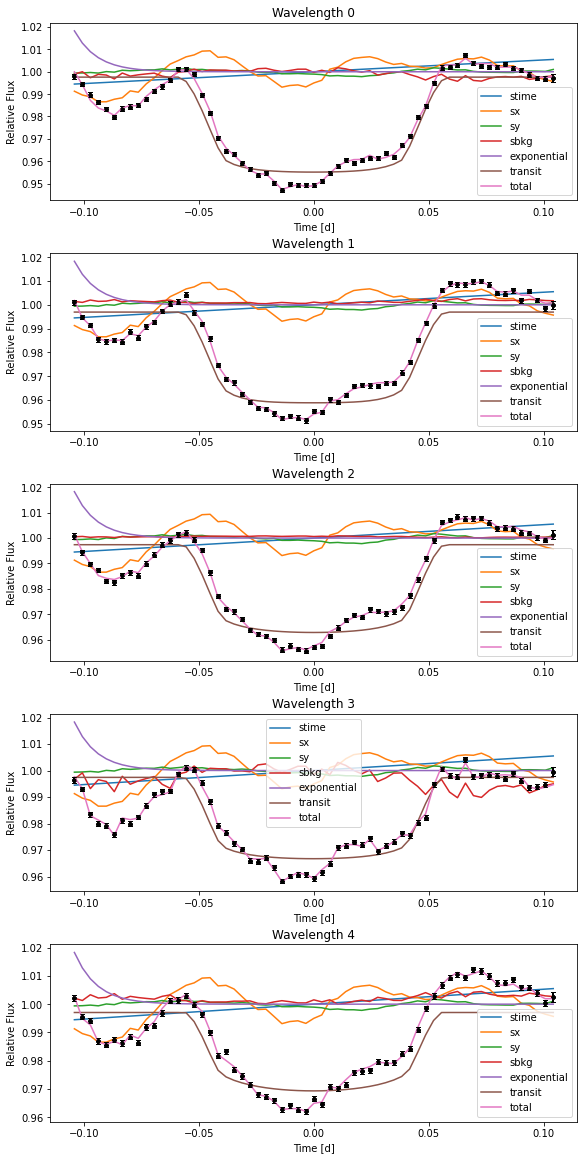

In [124]:
cmod.plot_model()

We can also just choose to see a single model or wavelength:

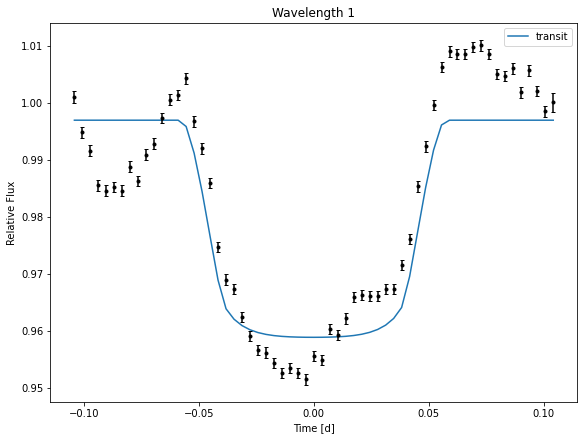

In [125]:
cmod._chromatic_models['transit'].plot_model(wavelength=1)

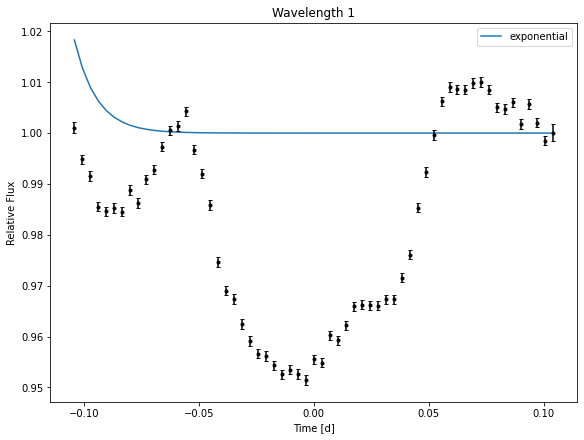

In [126]:
cmod._chromatic_models['exponential'].plot_model(wavelength=1)

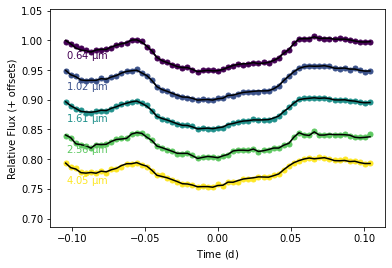

In [127]:
# plot the 2D light curves for each wavelength with the model (black) now overlaid
cmod.plot_lightcurves()

No model attached to data. Running `add_model_to_rainbow` now. You can access this data later using [self].data_with_model


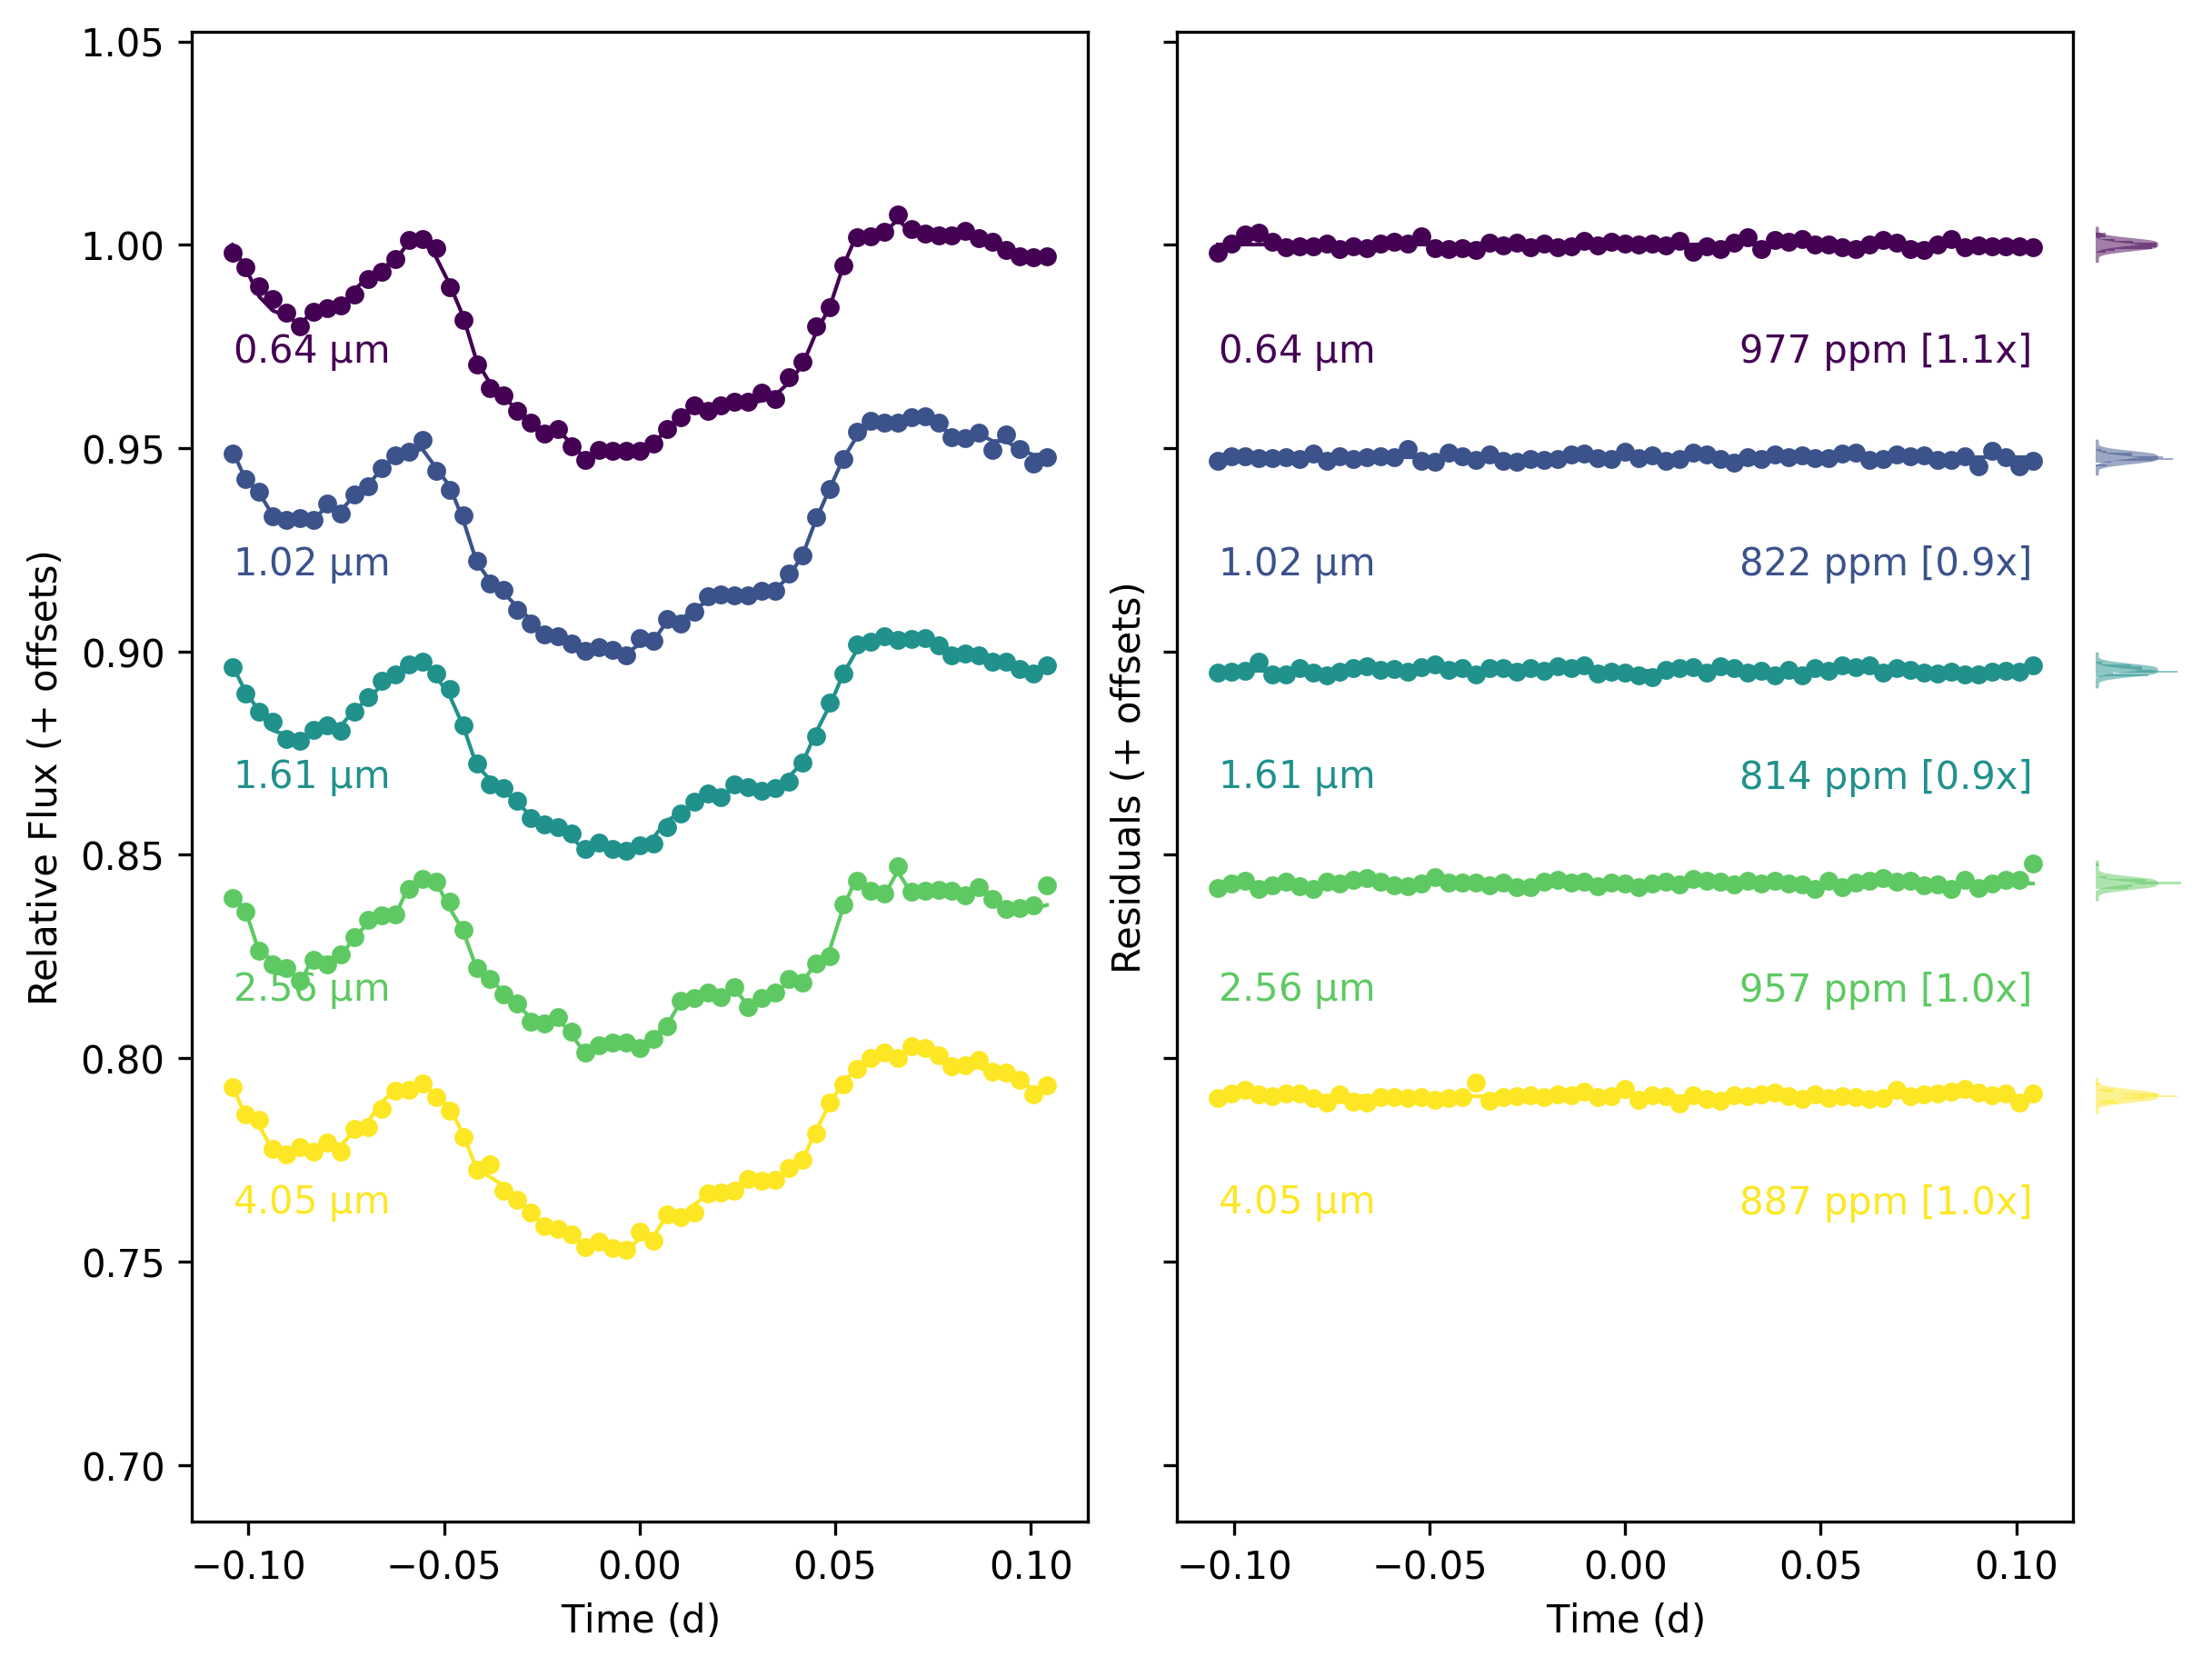

In [128]:
cmod.plot_with_model_and_residuals()

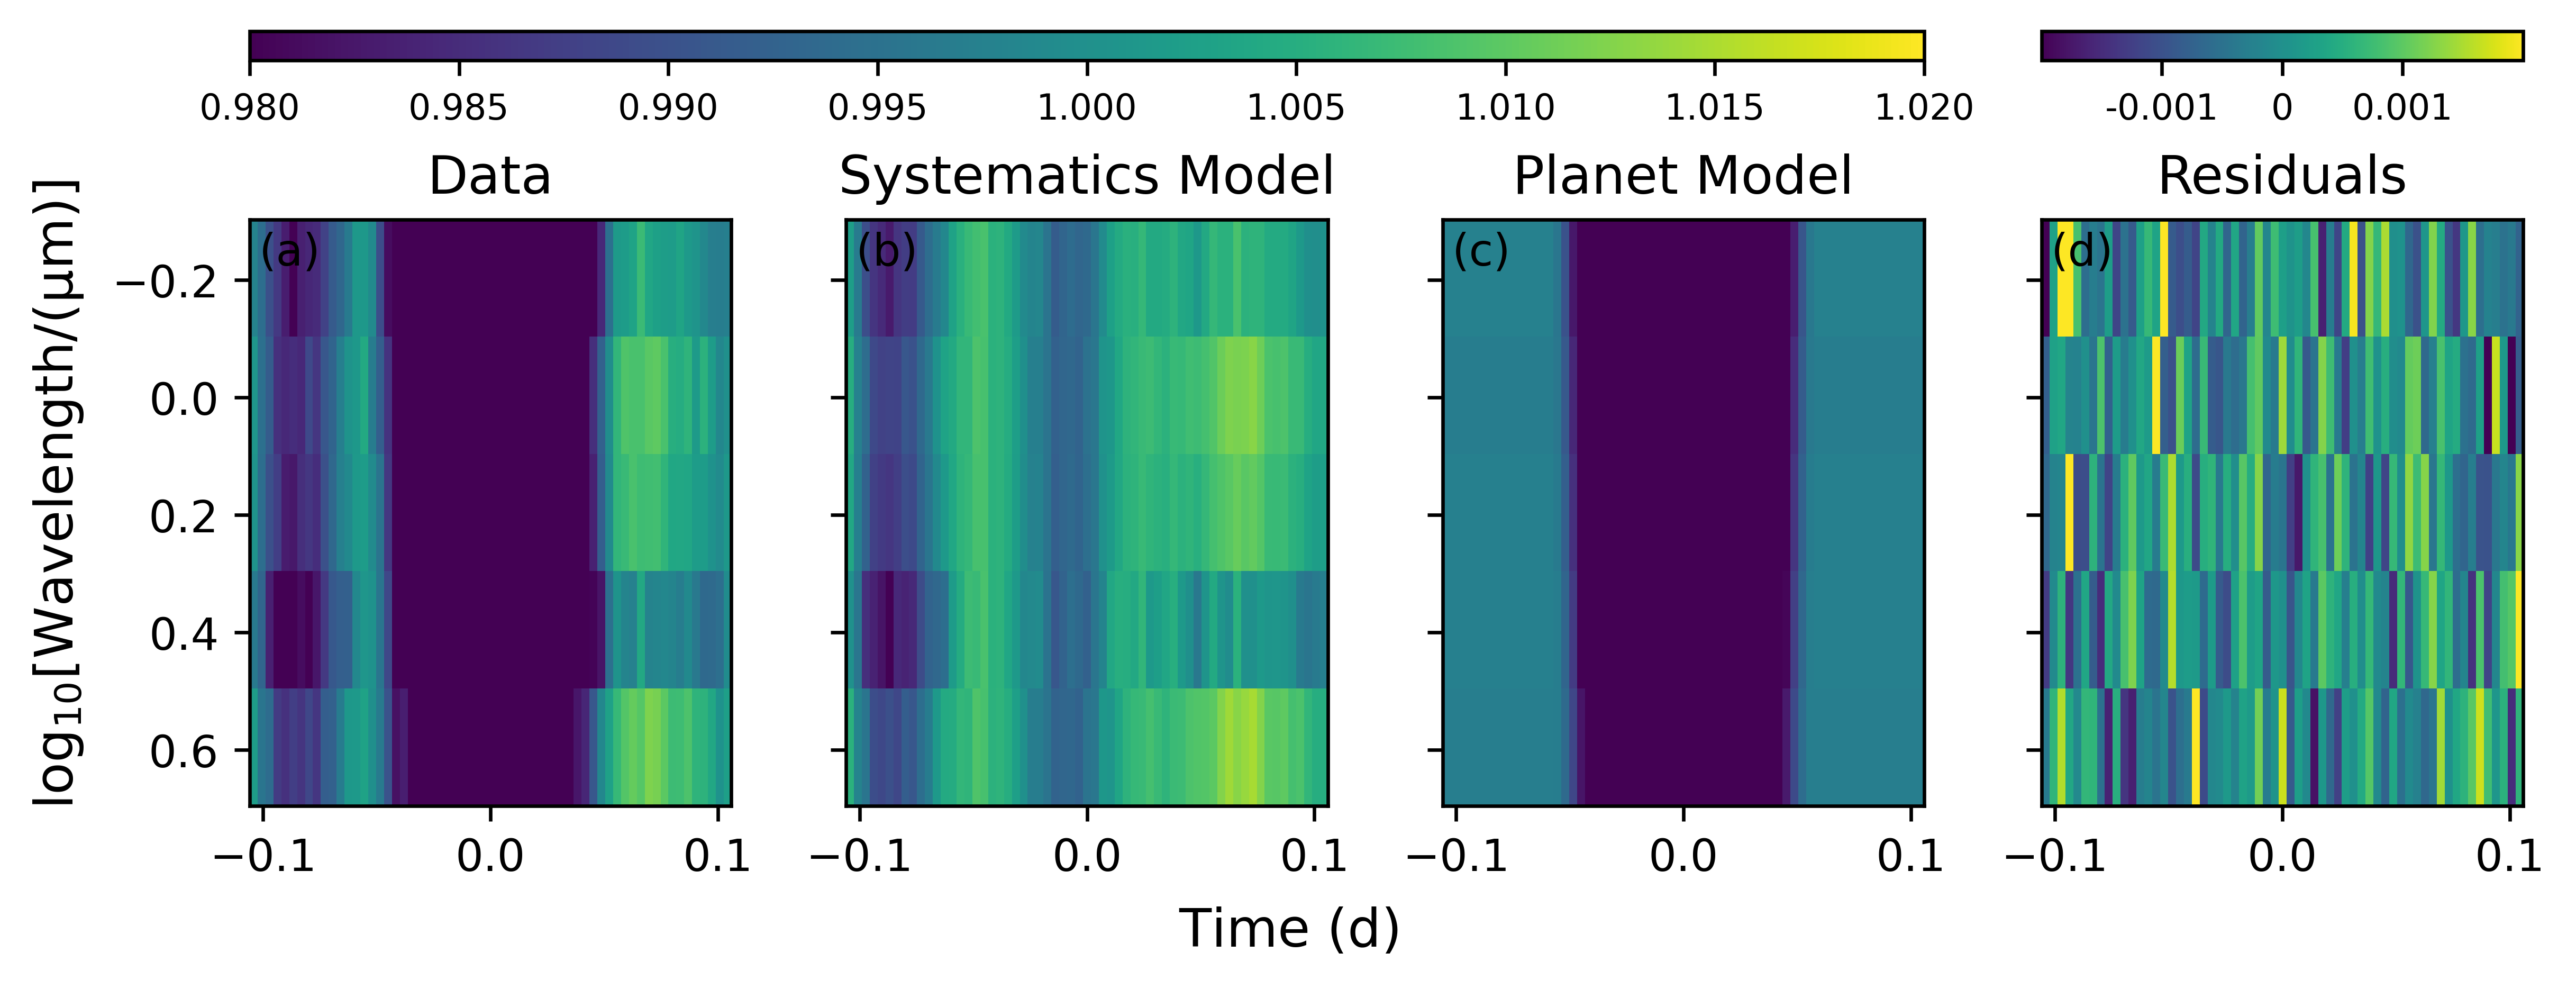

In [129]:
# plot the 3D light curves (flux as a function of time and wavelength) with the residuals
cmod.imshow_with_models(vspan_residuals=0.002)

  0%|          | 0/5 [00:00<?, ?it/s]

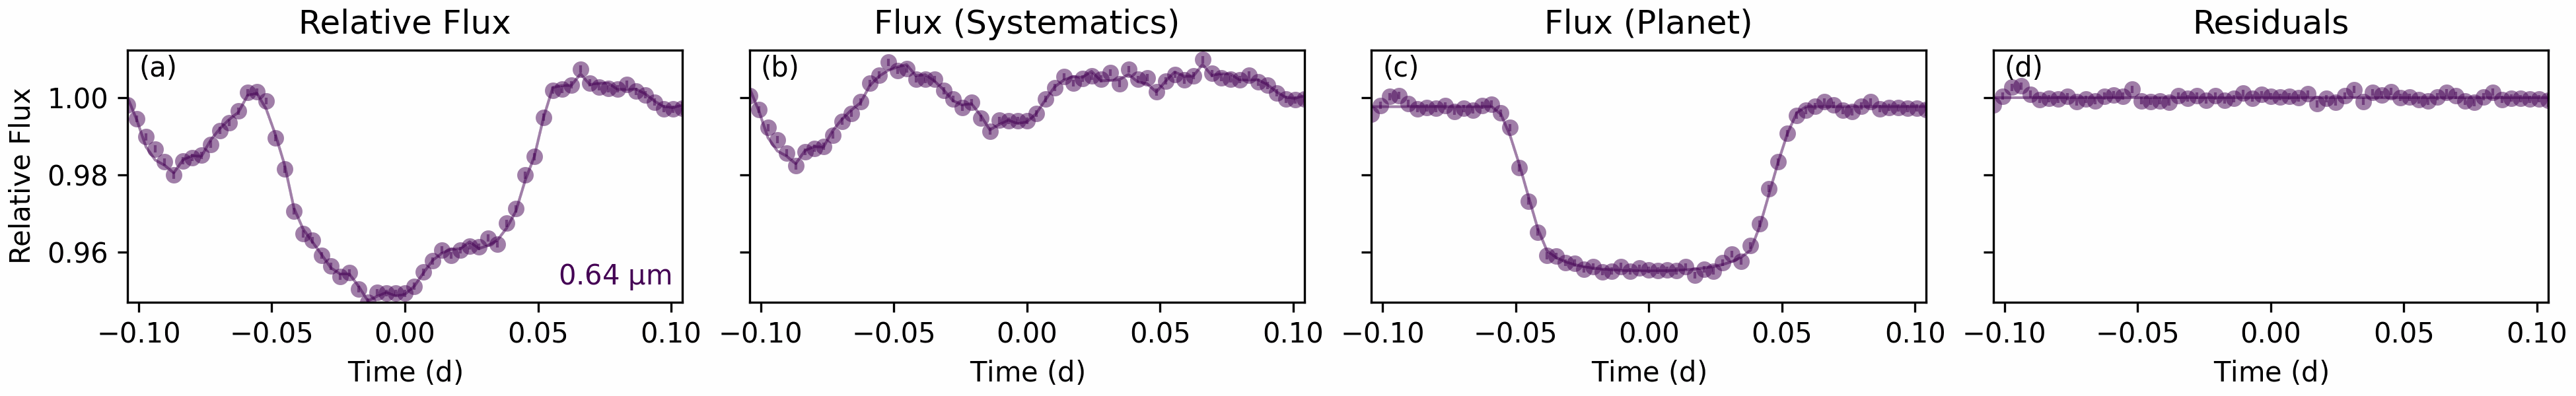

In [343]:
cmod.animate_with_models()#orientation='vertical', panelsize=(7,2))

Plot the transmission spectrum:

Error applying plot_transmission_spectrum to <chromatic polynomial model 'stime' 🌈>: 'PolynomialModel' object has no attribute 'plot_transmission_spectrum'
Error applying plot_transmission_spectrum to <chromatic polynomial model 'sx' 🌈>: 'PolynomialModel' object has no attribute 'plot_transmission_spectrum'
Error applying plot_transmission_spectrum to <chromatic polynomial model 'sy' 🌈>: 'PolynomialModel' object has no attribute 'plot_transmission_spectrum'
Error applying plot_transmission_spectrum to <chromatic polynomial model 'sbkg' 🌈>: 'PolynomialModel' object has no attribute 'plot_transmission_spectrum'
Error applying plot_transmission_spectrum to <chromatic exponential model 'exponential' 🌈>: 'ExponentialModel' object has no attribute 'plot_transmission_spectrum'


/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_radius_ratio_neg_error"] = (


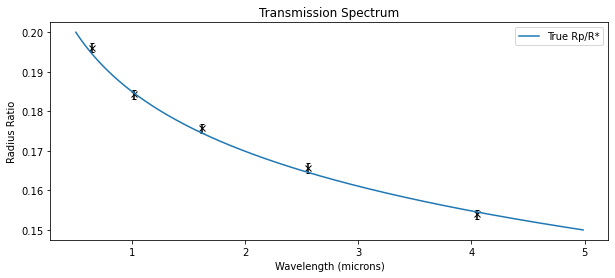

In [131]:
cmod.plot_transmission_spectrum(uncertainty=['hdi_16%','hdi_84%'])
plt.plot(SimulatedRainbow().wavelength, np.linspace(0.2, 0.15, SimulatedRainbow().nwave), label="True Rp/R*")
plt.legend();


For Entire Simultaneous Fit:
Fitted Parameters:
 stime_p_1[0], sx_p_1[0], sy_p_1[0], sbkg_p_1[0], transit_radius_ratio[0], transit_radius_ratio[1], transit_radius_ratio[2], transit_radius_ratio[3], transit_radius_ratio[4], transit_baseline[0], transit_baseline[1], transit_baseline[2], transit_baseline[3], transit_baseline[4], exponential_A[0], exponential_decay_time[0], transit_epoch[0], transit_impact_parameter[0], transit_stellar_radius[0], transit_stellar_mass[0], transit_a_R*[0], transit_limb_darkening[0, 0], transit_limb_darkening[0, 1], transit_limb_darkening[1, 0], transit_limb_darkening[1, 1], transit_limb_darkening[2, 0], transit_limb_darkening[2, 1], transit_limb_darkening[3, 0], transit_limb_darkening[3, 1], transit_limb_darkening[4, 0], transit_limb_darkening[4, 1]

Degrees of Freedom = n_waves (5) * n_times (61) - n_fitted_parameters (31) = 274
chi squared = 263.47167494883
Reduced chi squared = 0.9615754560176278
For 274 degrees of freedom, a model that 
    accurately d

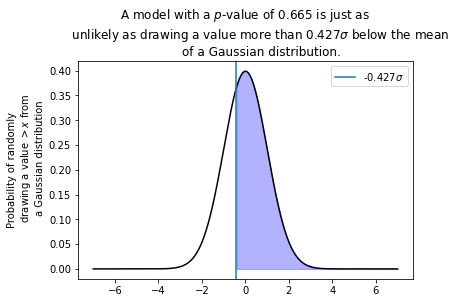

In [132]:
cmod.chi_squared(plot=True)

/Users/camu5866/opt/anaconda3/envs/chromaticfitting/lib/python3.9/site-packages/chromatic_fitting/models/transit.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trans_table[f"{self.name}_radius_ratio_neg_error"] = (
MovieWriter imagemagick unavailable; using Pillow instead.


Error applying make_transmission_spectrum_table to <chromatic polynomial model 'stime' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic polynomial model 'sx' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic polynomial model 'sy' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic polynomial model 'sbkg' 🌈>: 'PolynomialModel' object has no attribute 'make_transmission_spectrum_table'
Error applying make_transmission_spectrum_table to <chromatic exponential model 'exponential' 🌈>: 'ExponentialModel' object has no attribute 'make_transmission_spectrum_table'


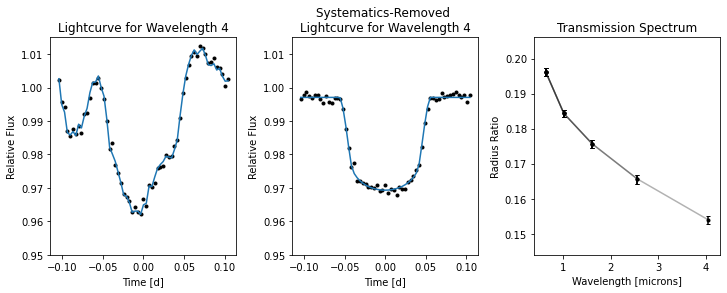

In [157]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
# plt.style.use('seaborn-pastel')


fig, ax = plt.subplots(ncols=3, nrows=1, sharex=False, sharey=False, figsize=(12,4))
plt.subplots_adjust(wspace=0.3)

line, = ax[0].plot(cmod.data.time, cmod.data.flux[0,:],'k.')
model, = ax[0].plot(cmod.data.time, cmod.data_with_model.model[0,:])
ax[0].set_ylim(0.95,1.015)
ax[0].set_ylabel("Relative Flux")
ax[0].set_xlabel("Time [d]")
title = ax[0].set_title(f"Lightcurve for Wavelength 0")


detrended, = ax[1].plot(cmod.data.time, cmod.data.flux[0,:]/cmod.data_with_model.fluxlike['systematics_model'][0,:],'k.')
planet_model, = ax[1].plot(cmod.data.time, cmod.data_with_model.fluxlike['planet_model'][0,:])
ax[1].set_ylabel("Relative Flux")
ax[1].set_ylim(0.95,1.015)
ax[1].set_xlabel("Time [d]")
title1 = ax[1].set_title(f"Systematics-Removed \nLightcurve for Wavelength {i}")

# title = ax[0].set_title(f"Lightcurve for Wavelength 0")

# cmod.plot_transmission_spectrum(uncertainty=['hdi_16%','hdi_84%'], ax=ax[1])#, plotkw={'alpha':0.3})

transmission_spectrum = cmod.make_transmission_spectrum_table(uncertainty=['hdi_16%','hdi_84%'])
ax[2].set_ylim(transmission_spectrum['transit_radius_ratio'].min()-0.01,
               transmission_spectrum['transit_radius_ratio'].max()+0.01)
ax[2].set_xlim(transmission_spectrum['wavelength'].min().to_value('micron')-0.25,
               transmission_spectrum['wavelength'].max().to_value('micron')+0.25)
ax[2].set_ylabel("Radius Ratio")
ax[2].set_xlabel("Wavelength [microns]")
ax[2].set_title("Transmission Spectrum")
# trspec, = ax[1].plot([t.to_value('micron') for t in temp_table['wavelength']], temp_table['transit_radius_ratio'],'kx')

# plt.ylim(-2,2)
# plt.xlim(0,4)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    
    line.set_data(cmod.data.time, cmod.data.flux[i,:])
    model.set_data(cmod.data.time, cmod.data_with_model.model[i,:])
    title.set_text(f"Lightcurve for Wavelength {i}")
    
    detrended.set_data(cmod.data.time, cmod.data.flux[i,:]/cmod.data_with_model.fluxlike['systematics_model'][i,:])
    planet_model.set_data(cmod.data.time, cmod.data_with_model.fluxlike['planet_model'][i,:])
    title1.set_text(f"Systematics-Removed \nLightcurve for Wavelength {i}")
    
    
    temp_table = {'transit_radius_ratio':transmission_spectrum['transit_radius_ratio'].values[:i+1],
              'transit_radius_ratio_neg_error':transmission_spectrum['transit_radius_ratio_neg_error'].values[:i+1],
              'transit_radius_ratio_pos_error':transmission_spectrum['transit_radius_ratio_pos_error'].values[:i+1],
             'wavelength':transmission_spectrum['wavelength'].values[:i+1]}
    
    wave = [t.to_value('micron') for t in temp_table['wavelength']]
    ax[2].plot(wave, temp_table['transit_radius_ratio'], 'k', alpha=0.3)
    ax[2].plot(wave, temp_table['transit_radius_ratio'], 'k.')
    plt.errorbar(
        wave, 
        temp_table['transit_radius_ratio'],
        yerr=[
                temp_table['transit_radius_ratio_neg_error'],
                temp_table['transit_radius_ratio_pos_error'],
            ],
        color="k",
        capsize=2,
        linestyle="None"
    )


    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=cmod.data.nwave, interval=500, blit=True)


anim.save('sine_wave.gif', writer='imagemagick')

In [139]:
cmod.data_with_model.fluxlike['systematics_model']

array([[1.00239473, 0.99656388, 0.9895717 , 0.98615328, 0.98481325,
        0.98282292, 0.98622386, 0.98725141, 0.98713547, 0.99137431,
        0.99433377, 0.99669415, 0.99857844, 1.00298864, 1.00542644,
        1.0069727 , 1.0078681 , 1.00845728, 1.00558033, 1.00587556,
        1.00424272, 1.00193448, 0.99914263, 0.99804526, 0.99837078,
        0.99535515, 0.99158162, 0.99298483, 0.99410886, 0.99322574,
        0.99364558, 0.99576415, 0.99933968, 1.00268897, 1.00449379,
        1.00536899, 1.00516954, 1.00671139, 1.00431733, 1.00434503,
        1.00458281, 1.00593561, 1.00401349, 1.0035662 , 1.00139084,
        1.00416524, 1.00656949, 1.00547504, 1.00547866, 1.00850857,
        1.00571652, 1.00608456, 1.00607508, 1.00448372, 1.00446413,
        1.00452831, 1.00330767, 1.00143772, 0.99999129, 0.9997679 ,
        1.00036652],
       [1.00488771, 0.99756551, 0.99426499, 0.98875655, 0.98783629,
        0.98823095, 0.98803254, 0.99091938, 0.9900285 , 0.99371488,
        0.99619246, 1.00037

In [335]:
def get_animation_writer_and_displayer(filename="animation.html", **kw):
    """
    Create the right animation writer based on filename.

    Parameters
    ----------
    filename : str
        The filename of the movie to create.

    Returns
    -------
    writer : MovieWriter
        The matplotlib writer object.
    displayer : ?
        The
    """

    # define the options
    writers = {"html": ani.HTMLWriter, "mp4": ani.FFMpegWriter, "gif": ani.PillowWriter}
    warnings = {
        "html": "Please try `pip insall matplotlib --upgrade` and rerunning?",
        "mp4": "Please try `conda install ffmpeg` and rerunning?",
        "gif": "Please try `pip insall matplotlib --upgrade` and rerunning?",
    }
    from IPython.display import HTML, Video, Image

    displayers = {"html": HTML, "mp4": Video, "gif": Image}

    # get the writer object
    suffix = filename.split(".")[-1]
    writer = writers[suffix](**kw)
    displayer = displayers[suffix]

    if writer.isAvailable():
        return writer, displayer
    else:
        raise ValueError(
            f"""
        The writer {writer} needed for your `.{suffix}` file is not available.
        {warnings[suffix]}
        """
        )
        
def setup_animated_scatter(self, ax=None, figurekw={}, scatterkw={}, textkw={}, modelkw={}, speckw={}):
    """
    Wrapper to set up the basics of animate-able plot.

    This works for any general plot that has a single-color
    line or set of points (using `plt.plot`), with a text
    label in the upper right corner.

    Parameters
    ----------
    ax : Axes, optional
        The axes into which the plot should be drawn.
        If None, a new one will be created.
    figurekw : dict, optional
        A dictionary of keywords to be passed to `plt.figure`
    scatterkw : dict, optional
        A dictionary of keywords to be passed to `plt.scatter`
    textkw : dict, optional
        A dictionary of keywords to be passed to `plt.text`
    """

    # make sure the ax and figure are defined
    if ax is None:
        kw = dict(facecolor="white")
        kw.update(**figurekw)
        fig, ax = plt.subplots(**kw)
    else:
        fig = ax.get_figure()

    plt.sca(ax)

    this_scatterkw = dict(c=[], cmap=self.cmap, norm=self.norm)
    this_scatterkw.update(**scatterkw)
    scatter = plt.scatter([], [], **this_scatterkw)

    this_textkw = dict(
        x=0.98, y=0.96, s="", ha="right", va="top", transform=ax.transAxes
    )
    this_textkw.update(**textkw)
    text = plt.text(**this_textkw)
    
    this_modelkw = dict()
    this_modelkw.update(**modelkw)
    model = plt.plot([],[], linestyle='-', c='k', alpha=0.3, **this_modelkw)
    
    this_speckw = dict(c=[], cmap=self.cmap)
    this_speckw.update(**speckw)
    spec = plt.scatter([], [], **this_speckw)
    
    plt.title(self.get("title"))

    # return a dictionary with things that will be useful to hang onto
    return dict(fi=fig, ax=ax, scatter=scatter, text=text, model=model, spec=spec)


def setup_animate_transmission_spectrum(
    self,
    transmission_spectrum,
    ax=None,
    quantity="flux",
    xlim=[None, None],
    ylim=[None, None],
    cmap=None,
    vmin=None,
    vmax=None,
    ylabel=None,
    scatterkw={},
    textkw={},
):
    """
    Setup an animation to how the lightcurve changes
    as we flip through every wavelength.

    Parameters
    ----------
    ax : Axes, optional
        The axes into which this animated plot should go.
    quantity : string, optional
        Which fluxlike quantity should be retrieved? (default = 'flux')
    xlim : tuple, optional
        Custom xlimits for the plot
    ylim : tuple, optional
        Custom ylimits for the plot
    cmap : str, Colormap, optional
        The color map to use for expressing wavelength
    vmin : Quantity, optional
        The minimum value to use for the wavelength colormap
    vmax : Quantity, optional
        The maximum value to use for the wavelength colormap
    scatterkw : dict, optional
        A dictionary of keywords to be passed to `plt.scatter`
        so you can have more detailed control over the plot
        appearance. Common keyword arguments might include:
        `[s, c, marker, alpha, linewidths, edgecolors, zorder]` (and more)
        More details are available at
        https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    textkw : dict
        A dictionary of keywords passed to `plt.text`
        so you can have more detailed control over the text
        appearance. Common keyword arguments might include:
        `[alpha, backgroundcolor, color, fontfamily, fontsize,
          fontstyle, fontweight, rotation, zorder]` (and more)
        More details are available at
        https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
    """

    # self._make_sure_cmap_is_defined(cmap=cmap, vmin=vmin, vmax=vmax)

    with quantity_support():
        
        rr = transmission_spectrum #transmission_spectrum['transit_radius_ratio']
        wavelength = self.wavelength #transmission_spectrum['wavelength']
        ax[2].plot(wavelength, rr, 'k',alpha=0.3)
        
        ylims = [[0.995 * np.nanmin(self.get(quantity)),1.005 * np.nanmax(self.get(quantity))],
                 [0.995 * np.nanmin(self.get(quantity)),1.005 * np.nanmax(self.get(quantity))],
                 [0.95 * np.nanmin(rr),1.05 * np.nanmax(rr)]]
                                                                        
        xlims = [[np.nanmin(self.time),np.nanmax(self.time)],
                [np.nanmin(self.time),np.nanmax(self.time)],
                [0.5 * np.nanmin(wavelength), 1.1 * np.nanmax(wavelength)]]
                                                                         
        xlabels = [f"{self._time_label} ({self.time.unit.to_string('latex_inline')})",
                 f"{self._time_label} ({self.time.unit.to_string('latex_inline')})",
                 f"{self._wave_label} ({self.wavelength.unit.to_string('latex_inline')})"]
                                                                    
        ylabels = [quantity, quantity, 'Radius Ratio']
        
        titles = ["Lightcurve", "Systematics-Detrended Lightcurve","Transmission Spectrum"]
        
        self._animate_lightcurves_components = []  
        print(ax)
        
        for i, ax_i in enumerate(ax):

            # keep track of the things needed for the animation
            self._animate_lightcurves_components.append(setup_animated_scatter(self,
                ax=ax_i, scatterkw=scatterkw, textkw=textkw, modelkw=scatterkw
            ))
            
#             print(self._animate_lightcurves_components)

            ax_i = self._animate_lightcurves_components[i]["ax"]

            # set the plot limits
            ax_i.set_xlim(xlims[i][0],xlims[i][1]) 
            ax_i.set_ylim(ylims[i][0],ylims[i][1]) 
#             ax_i.set_xlim(xlim[0] or np.nanmin(self.time), xlim[1] or np.nanmax(self.time))
#             ax_i.set_ylim(
#                 ylim[0] or 0.995 * np.nanmin(self.get(quantity)),
#                 ylim[1] or 1.005 * np.nanmax(self.get(quantity)),
#             )
                                                    
            # set the axis labels
            ax_i.set_xlabel(xlabels[i])
            ax_i.set_ylabel(ylabels[i])
#             ax_i.set_xlabel(
#                 f"{self._time_label} ({self.time.unit.to_string('latex_inline')})"
#             )
#             ax_i.set_ylabel(ylabel or quantity)

            ax_i.set_title(titles[i])

            # guess a good number of digits to round
            ndigits = np.minimum(
                int(np.floor(np.log10(np.min(np.diff(self.wavelength)).value))), 0
            )
            format_code = f"{{:.{-ndigits}f}}"

        def update(frame):
            """
            This function will be called to update each frame
            of the animation.

            Parameters
            ----------
            frame : int
                An integer that will advance with each frame.
            """

            # pull out the x and y values to plot
            x, y, _ = self.get_ok_data_for_wavelength(frame, y=quantity)
                             
            x_model = self.time
            y_model = self.fluxlike['model'][frame]                                                            
            y_model_planet = self.fluxlike['planet_model'][frame]  
            y_model_sys = self.fluxlike['systematics_model'][frame]  
                                                                         
            # x = self.time
            # y = self.flux[frame]
            c = self.wavelength[frame].to("micron").value * np.ones(self.ntime)

            # update the label in the corner
            self._animate_lightcurves_components[0]["text"].set_text(
                f"w = {format_code.format(self.wavelength[frame].value)} {self.wavelength.unit.to_string('latex')}"
            )
            self._animate_lightcurves_components[1]["text"].set_text(
                f"w = {format_code.format(self.wavelength[frame].value)} {self.wavelength.unit.to_string('latex')}"
            )

            # update the plot data
            self._animate_lightcurves_components[0]["scatter"].set_offsets(
                np.transpose([x, y])
            )
            self._animate_lightcurves_components[0]["scatter"].set_array(c)
            
            # update the plot data
            self._animate_lightcurves_components[1]["scatter"].set_offsets(
                np.transpose([x, y/y_model_sys])
            )
            self._animate_lightcurves_components[1]["scatter"].set_array(c)
                                                                         
            # update the model data
            self._animate_lightcurves_components[0]["model"][0].set_data(
                x, y_model
            )
            self._animate_lightcurves_components[1]["model"][0].set_data(
                x, y_model_planet
            )
            
            # update transmission spectrum
            self._animate_lightcurves_components[2]["spec"].set_offsets(
                np.transpose([self.wavelength[:frame+1].to("micron").value, rr[:frame+1]])
            )
            self._animate_lightcurves_components[2]["spec"].set_array(c)
#             print(c[frame], rr[frame])

            return (
                [(alc['text'],alc['scatter'], alc['model'], alc['spec']) for alc in self._animate_lightcurves_components]
            )

        # hold onto this update function in case we need it elsewhere
        upd = update
        for i in range(len(ax)):
            self._animate_lightcurves_components[i]["update"] = upd


def animate_transmission_spectrum(
    self,
    transmission_spectrum,
    filename="animated-transmission-spectrum.gif",
    fps=2,
    dpi=None,
    bitrate=None,
    **kwargs,
):
    """
    Create an animation to show how the lightcurve changes
    as we flip through every wavelength.

    Parameters
    ----------
    filename : str
        Name of file you'd like to save results in.
        Currently supports only .gif or .html files.
    fps : float
        frames/second of animation
    ax : Axes
        The axes into which this animated plot should go.
    xlim : tuple
        Custom xlimits for the plot
    ylim : tuple
        Custom ylimits for the plot
    cmap : str,
        The color map to use for expressing wavelength
    vmin : Quantity
        The minimum value to use for the wavelength colormap
    vmax : Quantity
        The maximum value to use for the wavelength colormap
    scatterkw : dict
        A dictionary of keywords to be passed to `plt.scatter`
        so you can have more detailed control over the plot
        appearance. Common keyword arguments might include:
        `[s, c, marker, alpha, linewidths, edgecolors, zorder]` (and more)
        More details are available at
        https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    textkw : dict
        A dictionary of keywords passed to `plt.text`
        so you can have more detailed control over the text
        appearance. Common keyword arguments might include:
        `[alpha, backgroundcolor, color, fontfamily, fontsize,
          fontstyle, fontweight, rotation, zorder]` (and more)
        More details are available at
        https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.text.html
    """
    my_dpi = 96
    fig, axes = plt.subplots(
#                             ncols=2, 
#                            nrows=2, 
                           facecolor='w',
#                            gridspec_kw={'width_ratios': [1,1,2]},
                           figsize=(1920/(1.7*my_dpi), 1080/(2.7*my_dpi)), dpi=my_dpi)
#     plt.subplots_adjust(wspace=0.35)
    plt.subplots_adjust(hspace=0.5)
    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)
    ax4 = plt.subplot(2,1,2)
    ax = [ax1, ax2, ax4]
    setup_animate_transmission_spectrum(self,transmission_spectrum, ax=ax, **kwargs)

    filename = self._label_plot_file(filename)

    # initialize the animator
    writer, displayer = get_animation_writer_and_displayer(
        filename=filename, fps=fps, bitrate=bitrate
    )

    # set up to save frames directly into the animation
#     print(self._animate_lightcurves_components)
    for i, ax_i in enumerate(ax):
        figure = self._animate_lightcurves_components[i]["fi"]
        with writer.saving(figure, filename, dpi or figure.get_dpi()):
            for j in tqdm(range(self.nwave), leave=False):
                self._animate_lightcurves_components[i]["update"](j)
                writer.grab_frame()

    # close the figure that was created
    plt.close(figure)

    # display the animation
    from IPython.display import display

    try:
        display(displayer(filename, embed=True))
    except TypeError:
        display(displayer(filename))

[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:xlabel='$\\mathrm{\\mu m}$'>]


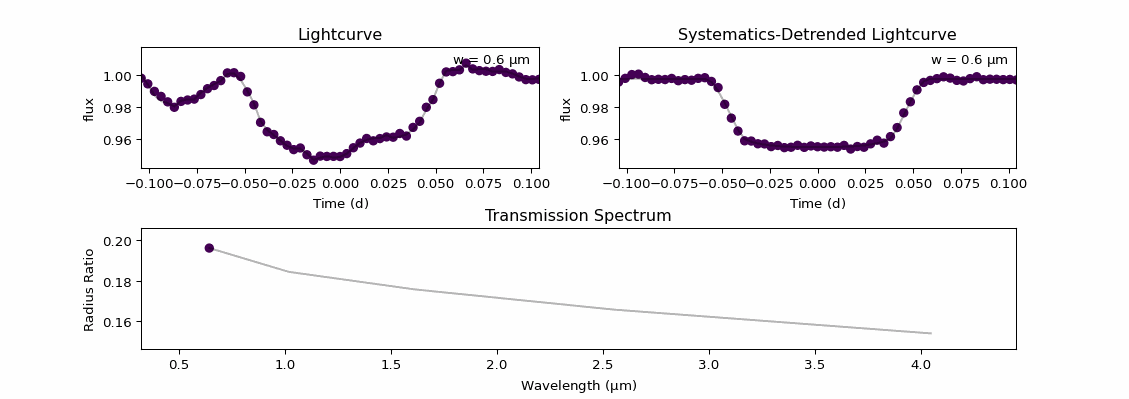

In [336]:
animate_transmission_spectrum(cmod.data_with_model, transmission_spectrum= transmission_spectrum['transit_radius_ratio'].values)

In [165]:
transmission_spectrum['transit_radius_ratio'].values

array([0.1960653, 0.1843362, 0.1756667, 0.165684, 0.1539733], dtype=object)

In [175]:
cmod.data_with_model._wave_label

'Wavelength'